### Модель в машинном обучении - класс функций (или алгоритмов), параметризуемый набором чисел. Обучение модели - подбор значений параметров, на которых модель показывает наилучший результат (чаще всего в терминах функции потерь) на обучающей выборке. 

### Эти факты известны всем, однако реализация такого подбора - нетривиальная и в общем случае нерешаемая задача, однако существует ряд эвристик, позволяющих с хорошей точностью приближать оптимальные значения параметров. В этой лекции мы поговорим о некоторых из них в контексте поиска значений, минимизирующих заданную функцию потерь.

# Эволюционные алгоритмы

Самая простая, но тем не менее далеко не самая плохая идея - случайно подбирать параметры, опираясь на полученные ранее результаты. Так, для оптимизации небольших моделей используются многочисленные вариации следующего алгоритма, называемого **эволюционным**:
1. Сэмплирование множества из N наборов параметров модели, называемого поколением;
2. Отбор K наборов, показавших лучший результат;
3. Скрещивание выбранных наборов между собой, получение N потомков, или новое поколение;
4. Повтор предыдущих шагов до сходимости.
Правила скрещивания сильно варьируются в зависимости от типа решаемой задачи и модели, однако общая структура алгоритма сохраняется неизменной. Такой подход интуитивен и не зависит от типа и архитектуры модели, а также от данных, однако имеет крайне высокую вычислительную сложность и низкую скорость сходимости (особенно при большом количестве оптимизируемых параметров). 


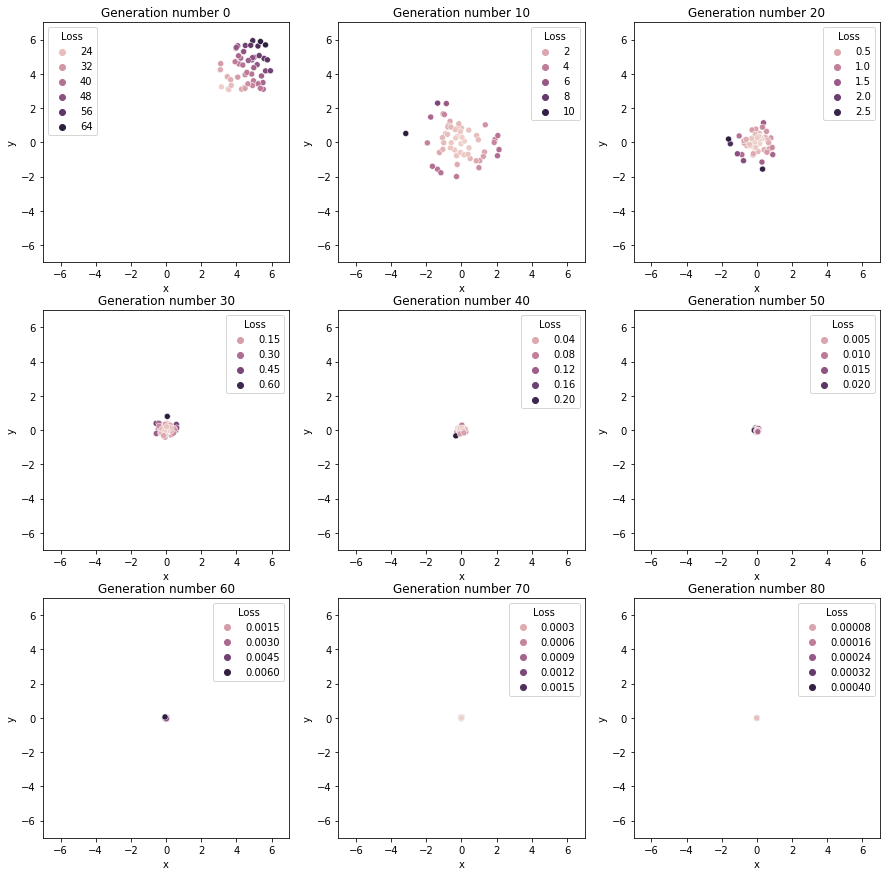

In [ ]:
# Визуализация эволюционного алгоритма на синтетическом примере

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

N = 50
K = 10

def Loss(x):
  return (x ** 2).sum(axis = -1)

def new_generation(best, mu):
  new_generation = []
  for i in range(len(best)):
    for j in range(i, len(best)):
      new_generation.append((best[i] + best[j]) / 2 + mu * np.random.randn(2))
  return np.array(new_generation)

generation = np.random.sample((N, 2)) * 3 + 3
fig, axis = plt.subplots(3, 3, figsize = (15, 15))
mu = 2
for i in range(81):
  result = Loss(generation)
  best_idx = np.argsort(result)[:K]
  best_points = generation[best_idx]
  if i % 10 == 0:
    temp = pd.DataFrame(np.hstack([generation, result.reshape(-1, 1)]), columns = ["x", "y", "Loss"])
    sns.scatterplot(x='x', y='y', hue='Loss', data=temp, ax = axis[i//30][(i // 10) % 3]);
    axis[i//30][(i // 10) % 3].set_title("Generation number " + str(i))
    axis[i//30][(i // 10) % 3].set(xlim=(-7, 7), ylim=(-7, 7))
    mu /= 2
  generation = new_generation(best_points, mu)

# Градиентный спуск

Эволюционные алгоритмы могут применяться для моделей, реализующих недифференцируемые функции. Если же мы имеем дело с моделью, преобразование которой почти всюду имеет первую производную (например, с линейной регрессией), то мы можем оптимизировать функцию потерь более эффективно.

Вы знаете, что градиент функции многих переменных указывает направление ее наискорейшего роста, а антиградиент (обратное направление) - наискорейшего убывания. Это замечательное свойство лежит в основе **градиентных** методов оптимизации, или Gradient Descent. Они рассматривают функцию потерь как функцию от параметров модели, находят ее  градиент в точке, соответствующей значениям параметров, и меняют их в направлении антиградиента.

Однако для реализации подобных алгоритмов необходимо уметь находить градиент функции потерь в каждой точке пространства. Для сложных моделей аналитически эта задача не решается в силу ее вычислительной сложности, но ее можно решить итерационно, или стохастически. Самый простой способ - передвигаться в направлении антиградиента с небольшим шагом, он получил крайне широкое распространение под названием Stochastic Gradient Descent, или SGD.
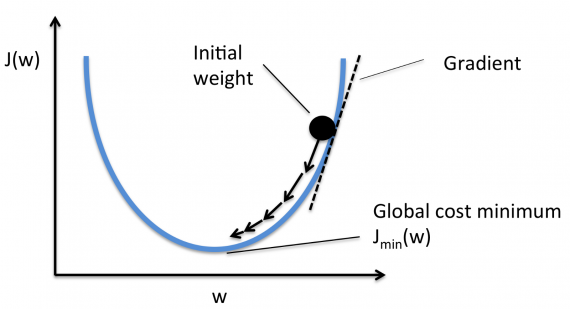

Однако у такого подхода есть две проблемы:
- Сходимость к локальному, а не глобальному минимуму;
- Неравномерная сходимость на разных примерах из датасета (в силу уникального вида функции потерь на каждом из них)

И если первая проблема общая для всего семейства градиентных методов и может быть решена разве что мультистартом из разных точек, то вторая может быть нивелирована при помощи некоторых эвристик, про которые мы сейчас и поговорим.

Первая из них - оптимизация параметров не на каждой итерации обучения (не на каждом объекте), а суммирование градиента по нескольким объектам сразу, называемым пакетом, или batch. Такое решение позволяет избежать чрезмерного влияния выбросов и шумов, содержащихся в данных и носит название **пакетное обучение**.

Вторая важная эвристика - использование "импульса" весов для коррекции направления движения, о ней хорошо рассказано в популярной статье на Хабре (https://habr.com/ru/post/318970/):
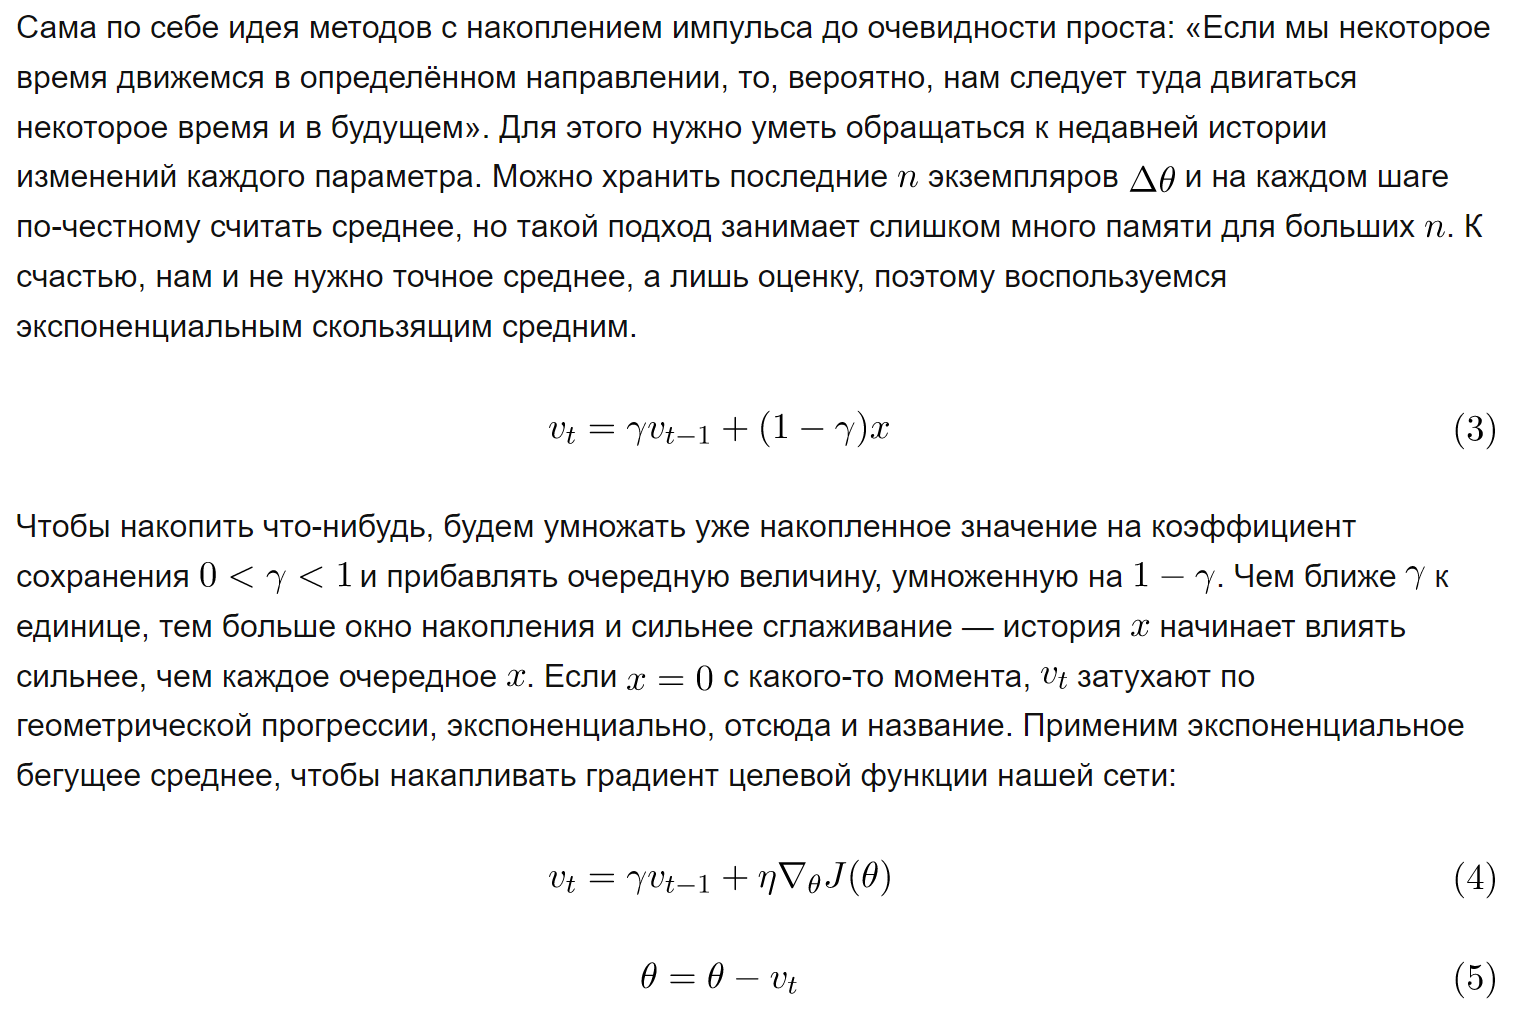


Данный алгоритм оптимизации модернизирует обычный SGD и в сочетании с пакетной оптимизацией показывает куда лучшую стабильность в процессе схождения и называется **Momentum**. Если же мы на каждом шаге будет дополнительно заглядывать вперед для подсчета градиента, то вышеописанный метод превратится в **Nesterov**.

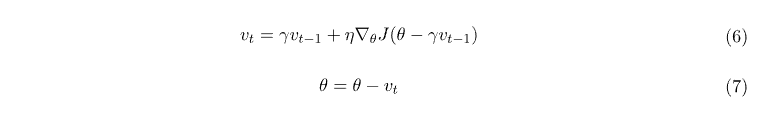

# RMSProp

Однако на этом проблемы методов оптимизации не заканчиваются. Как известно, разные группы нейронов берут на себя разные функции, и их градиенты могут значительно отличаться. Некоторые признаки могут быть крайне важными и встречаться редко, но при одинаковой скорости изменения весов модули сети, ответственные за данные признаки просто не будут успевать за скоростью обучения остальных и в итоге проигнорируют важную функцию. Стало быть, если группа весов меняется часто и сильно, мы хотим менять ее медленнее для нивелирования шума и стабилизации сходимости, а если напротив, редко и слабо, то нам бы хотелось корректировать ее сильнее, чтобы реагировать на редкую важную информацию.

На ум приходит достаточно очевидная реализация такого желания, и она неплохо зарекомендовала себя на практике. Мы можем использовать скользящее среднее, чтобы запоминать величину градиентов на предыдущих шагах (на практике используется корень из суммы квадратов производных) и нормировать градиент в соответствии с этой величиной. Ниже приведены формулы обновления весов.

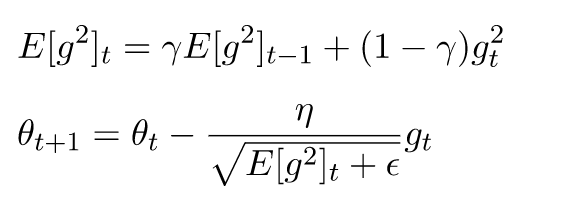

Эпсилон в этой формуле - небольшое положительное число для избегания нуля в знаменателе. 

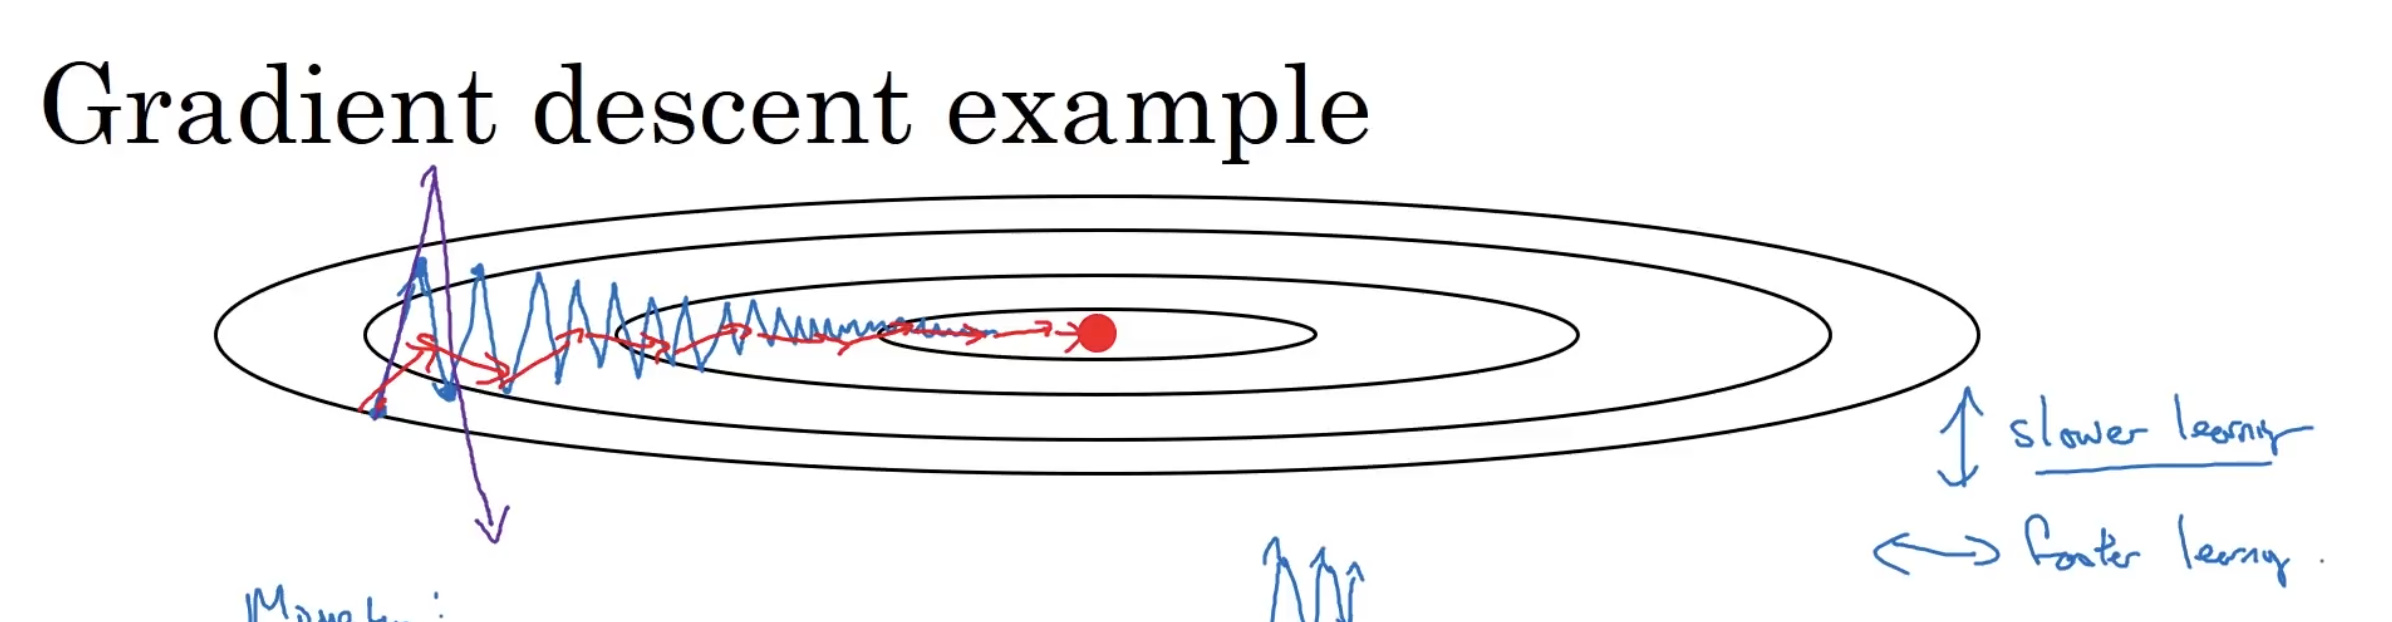

#Adam

Единственное, что хочется сделать, имея алгоритмы Nesterov и RMSProp - объединить их идеи. Именно для этого и был создан Adam - самый востребованный и используемый алгоритм оптимизации на сегодняшний день. По сути, это RMSProp, только вместо квадратов градиентов он накапливает квадраты смещения весов, которые считаются так же, как в Nesterov. Осталось сделать начальное значение среднего смещения большим (во избежание серьезной коррекции параметров до накопления информации о градиентах), и мы получим алгоритм, который учитывает "импульс" весов, а также частоту их изменения.

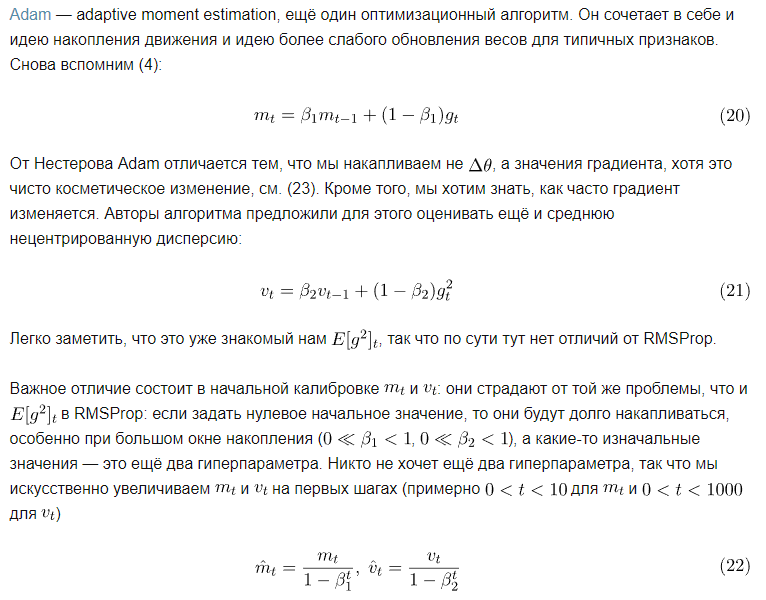

# Реализация градиентных алгоритмов

In [ ]:
from torch.optim import *
import torch
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def Loss(x):
  t = torch.norm(x * torch.tensor([1., 3.]))
  return t ** 2 + ((t - 1) ** 2 + 0.39) ** -1

x = torch.tensor([3., 1.5], requires_grad=True)
history_adam = []
adam = Adam([x], 0.01, betas = [0.97, 0.999])

for i in range(30000):
  adam.zero_grad()
  loss = Loss(x)
  history_adam.append(np.append(x.detach().numpy(), loss.item()))
  loss.backward()
  adam.step()

x = torch.tensor([3., 1.5], requires_grad=True)
history_rmsprop = []
rmsprop = RMSprop([x], 0.01, alpha = 0.999)

for i in range(30000):
  rmsprop.zero_grad()
  loss = Loss(x)
  history_rmsprop.append(np.append(x.detach().numpy(), loss.item()))
  loss.backward()
  rmsprop.step()

x = torch.tensor([3., 1.5], requires_grad=True)  
history_sgd = []
sgd = SGD([x], 0.01)

for i in range(30000):
  sgd.zero_grad()
  loss = Loss(x)
  history_sgd.append(np.append(x.detach().numpy(), loss.item()))
  loss.backward()
  sgd.step()


Text(0.5, 1.0, 'Loss образован этой кривой путем ее вращения вокруг оси Y')

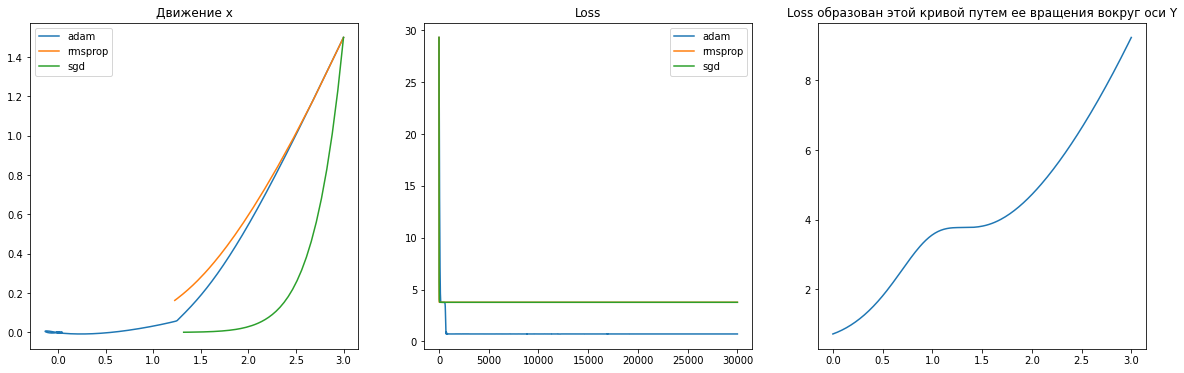

In [ ]:
history_adam, history_rmsprop, history_sgd = np.array(history_adam), np.array(history_rmsprop), np.array(history_sgd)
fig, ax = plt.subplots(1, 3, figsize = (20, 6))
ax[0].plot(history_adam[:, 0], history_adam[:, 1], label = "adam")
ax[0].plot(history_rmsprop[:, 0], history_rmsprop[:, 1], label = "rmsprop")
ax[0].plot(history_sgd[:, 0], history_sgd[:, 1], label = "sgd")
ax[0].set_title("Движение х")
ax[0].legend()

ax[1].plot(history_adam[:, 2], label = "adam")
ax[1].plot(history_rmsprop[:, 2], label = "rmsprop")
ax[1].plot(history_sgd[:, 2], label = "sgd")
ax[1].set_title("Loss")
ax[1].legend()

x = np.linspace(0, 3, 200)
y = x ** 2 + ((x - 1) ** 2 + 0.39) ** -1
ax[2].plot(x, y)
ax[2].set_title("Loss образован этой кривой путем ее вращения вокруг оси Y")

# Теория информации

Объекты датасета часто принято рассматривать как реализацию некоторого распределения случайных величин, а лейблы к ним - как реализацию некоторого условного распределения **P(y|x)**. Соответственно, чем более точно модель работает на датасете, тем лучше она приближает это условное распределение, и нам хотелось бы уметь измерять близость двух распределений (заданных датасетом и моделью) для минимизации "расстояния" между ними. Для этих целей используется так называемая дивергенция Кульбака-Лейблера, или DKL, являющаяся аналогом метрики на пространстве распределений (более точно, DKL задает на этом пространстве топологию, но не является метрикой, так как несимметрично и не удовлетворяет неравенству треугольника).
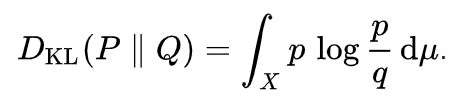

В теориии информации эта величина показывает, сколько бит информации о распределении *p* мы теряем, когда заменяем его на распределение *q*.
Вот некоторые ее важные свойства:
- Неотрицательность
- Равенство нулю только при совпадении *p* и *q* почти всюду
- Несимметричность
- Инвариантность относительно замены переменных
- Аддитивность для независимых переменных

У данной "метрики" много приложений и модификаций, таких как взаимная информация, энтропия Шеннона, условная энтропия и тп., разговор о каждом из них выходит за рамки настоящей лекции, сейчас мы обсудим лишь одно из них - **кросс-энтропию**.

# Кросс-энтропия

По своей сути это сумма энтропии распределения *p* и *DKL(p||q)*. При исследовании распределения *q* при условии постоянного *p* есть смысл минимизировать *DKL(p||q)*, так как энтропия *p* постоянна, однако чисто с вычислительной точки зрения **кросс-энтропия** считается проще, нижеприведенные формулы это доказывают:
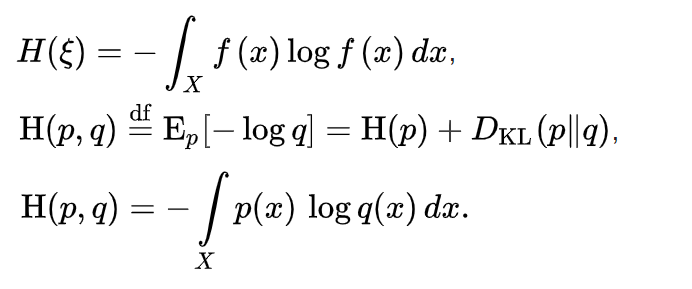